In [2]:
#import libraries
import os
import numpy as np
import torch
import matplotlib.pyplot as plt
from tcia_utils import nbia
from monai.bundle import ConfigParser, download
from monai.transforms import LoadImaged, Orientationd, EnsureChannelFirstd, Compose
from rt_utils import RTStructBuilder
from scipy.ndimage import label, measurements
import yaml
import json

In [3]:
datadir = 'data'

In [4]:
#download and open ct image
#retrieve nbia code from Cancer Imaging Archive
cart_name = 'nbia-94271757342218983'

#retrieve and download cart
cart_data = nbia.getSharedCart(cart_name)
df = nbia.downloadSeries(cart_data, format='df', path=datadir)

2025-09-08 14:23:25,598:INFO:Success - Token saved to global api_call_headers variable and expires at 2025-09-08 16:23:25.598423
2025-09-08 14:23:25,600:INFO:Accessing public data anonymously. To access restricted data use nbia.getToken() with your credentials.
2025-09-08 14:23:25,602:INFO:Calling getContentsByName with parameters {'name': 'nbia-94271757342218983'}
2025-09-08 14:23:26,212:INFO:Directory 'data' already exists.
2025-09-08 14:23:26,214:WARNING:Series 1.3.6.1.4.1.14519.5.2.1.1078.3273.915857074693225456170997227676 already downloaded and unzipped.
2025-09-08 14:23:26,215:INFO:Found 1 previously downloaded series.
2025-09-08 14:23:26,217:INFO:Attempting to download 0 new series.
2025-09-08 14:23:26,219:INFO:Calling getSeriesMetadata2 with parameters {'list': '1.3.6.1.4.1.14519.5.2.1.1078.3273.915857074693225456170997227676'}
2025-09-08 14:23:26,613:INFO:Downloaded 0 out of 0 targeted series.
0 failed to download.
1 were previously downloaded.


In [5]:
#variable to access cart data
CT_folder = os.path.join(datadir, '1.3.6.1.4.1.14519.5.2.1.1078.3273.915857074693225456170997227676')

In [6]:
datadict = {'image' : CT_folder, 'other_key':46}

In [7]:
preprocess_pipeline = Compose([
    LoadImaged(keys='image',image_only=True), #load image
    EnsureChannelFirstd(keys='image'), #add channel dimension
    Orientationd(keys='image',axcodes='LPS') #reorient CT image so it's not flipped
])

In [8]:
CT = preprocess_pipeline(datadict)

In [9]:
CT['image'].shape

torch.Size([1, 512, 512, 254])

In [10]:
CT_coronal_slice = CT['image'][0,:,256].cpu()

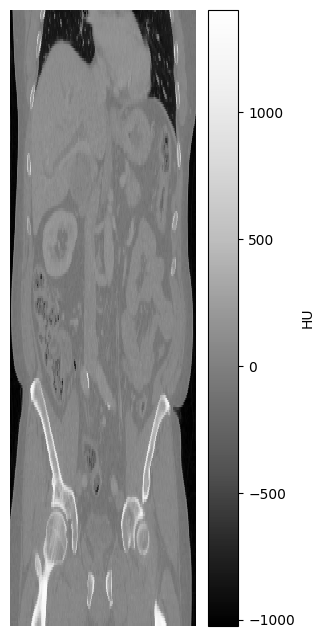

In [11]:
plt.figure(figsize=(3,8))
plt.pcolormesh(CT_coronal_slice.T, cmap='Greys_r')
plt.colorbar(label='HU')
plt.axis('off')
plt.show()

In [13]:
#download segmentation model
model_name = 'pancreas_ct_dints_segmentation'
download(name=model_name, bundle_dir=datadir)

2025-09-08 14:24:26,476 - INFO - --- input summary of monai.bundle.scripts.download ---
2025-09-08 14:24:26,477 - INFO - > name: 'pancreas_ct_dints_segmentation'
2025-09-08 14:24:26,478 - INFO - > bundle_dir: 'data'
2025-09-08 14:24:26,479 - INFO - > source: 'monaihosting'
2025-09-08 14:24:26,479 - INFO - > remove_prefix: 'monai_'
2025-09-08 14:24:26,481 - INFO - > progress: True
2025-09-08 14:24:26,481 - INFO - ---




inference.yaml: 0.00B [00:00, ?B/s]

Fetching 18 files:   0%|          | 0/18 [00:00<?, ?it/s]

In [14]:
#set paths to config files and model
model_path = os.path.join(datadir, model_name, 'models','model.pt')
config_path = os.path.join(datadir, model_name, 'configs', 'inference.yaml')

In [56]:
config = ConfigParser()
config.read_config(config_path)

In [57]:
print(config["device"])

cpu


In [58]:
preprocessing = config.get_parsed_content('preprocessing')
data = preprocessing({'image':CT_folder})

In [37]:
data

{'image': metatensor([[[[0., 0., 0.,  ..., 0., 0., 0.],
           [0., 0., 0.,  ..., 0., 0., 0.],
           [0., 0., 0.,  ..., 0., 0., 0.],
           ...,
           [0., 0., 0.,  ..., 0., 0., 0.],
           [0., 0., 0.,  ..., 0., 0., 0.],
           [0., 0., 0.,  ..., 0., 0., 0.]],
 
          [[0., 0., 0.,  ..., 0., 0., 0.],
           [0., 0., 0.,  ..., 0., 0., 0.],
           [0., 0., 0.,  ..., 0., 0., 0.],
           ...,
           [0., 0., 0.,  ..., 0., 0., 0.],
           [0., 0., 0.,  ..., 0., 0., 0.],
           [0., 0., 0.,  ..., 0., 0., 0.]],
 
          [[0., 0., 0.,  ..., 0., 0., 0.],
           [0., 0., 0.,  ..., 0., 0., 0.],
           [0., 0., 0.,  ..., 0., 0., 0.],
           ...,
           [0., 0., 0.,  ..., 0., 0., 0.],
           [0., 0., 0.,  ..., 0., 0., 0.],
           [0., 0., 0.,  ..., 0., 0., 0.]],
 
          ...,
 
          [[0., 0., 0.,  ..., 0., 0., 0.],
           [0., 0., 0.,  ..., 0., 0., 0.],
           [0., 0., 0.,  ..., 0., 0., 0.],
          

In [ ]:
#obtain model using network key from yaml file
model = config.get_parsed_content('network')

2025-09-08 15:00:21.214691 - Length of input patch is recommended to be a multiple of 32.


In [ ]:
model.load_state_dict(torch.load(model_path,map_location='cpu'))
model.eval();